<a href="https://colab.research.google.com/github/UCREL/Session-6-LLM-Based-Emotion-Analysis/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://github.com/UCREL/Session-6-LLM-Based-Emotion-Analysis/blob/main/banner_llm4emotions_summer_school.png?raw=1)

# **Introduction**
With the advent the transformer based of large language models (LLMs) such as BERT, LLAMA, Gemini etc., the NLP community has tapped into these models for developing new techniques and methodologies for a wide range of NLP tasks. One key NLP task that can benefit from such resources is the Emotion Analysis, which is a highly challenging NLP task.  

In this tutorial, we will learn how to:
1. **Apply LLMs to emotion classification tasks**
2. **Evaluate the performance of different models**
3. **Fine-tune a model to perform better on specific classification tasks**

To achieve the objectives above, we will follow the steps in the following sections:

- [**Section 1: Preamble**](#preamble) - download tutorial materials and set path to working folder.

- [**Section 2: Emotion Dataset Analysis**](#dataset-analysis) - load and analyse example emotion dataset.

- [**Section 3: Emotion Classification**](#classification) - perform emotion classification with existing models.

- [**Section 4: Model Evaluation**](#evaluation) - evaluate model performances on the dataset.

- [**Section 5: Guide to Model Fine-tuning**](#fine-tuning) - a quick guide to fine-tuning an emotion LLM.


<!--
These content will be pushed to the relevant sections:

tune three LLMs including BERT, RoBERTa, T5 and use them to classify emotion of some social media messages.

Sample training and testing data will be provided which derive from publicly available GoEmotion corpus, and we will test classifying text using two emotion classification schemes: GoEmotion Scheme (27 emotion categories) and Ekman’s scheme (6 categories). The GoEmotion emotion categories can be mapped into Ekman’s categories.

This tutorial will guide you on how to tune LLMs for emotion classification based on the two emotion schemes. To tune LLMs, we need to consider the charecteristics of each LLMs. For BERT and RoBERTa, they are similar which we need to connect them to the classification layer. On the other, T5 can generate text meaning we can ask the model directly by giving it an questions. Therefore, we do not need to create a classification layer for T5.  

There are three mains step for tuning LLMs. The first step involves preparing data and setingup datamodule for tuning process. The second step is about creating tuning process. The final step is to review the tuning process by visualising tuning stats, then save the model. We break down these three step as follows:  



1. Preparing data  
1.1 Load data from files  
1.2 Setup datamodule  
2. Tuning process   
2.1 Setup tuning process    
2.2 Setup parameters and load model/tokeniser  
2.3 Tune and test the model  
3. Review tuning stat    
3.1 Visualise tuning stat  
3.2 Save the model
-->


<a name="preamble"></a>
# **Section 1: Preamble**

## Downloading materials
To start, you need to download the materials required for this tutorial into our Colab space. These include the datasets and the python scripts required to perform other tasks.

Let's walk you through the process with the following exercise...

---

### **Exercise: 🏋️**
Copy and paste these two lines of code to download materials from this session's [GitHub repo](https://github.com/UCREL/Session-6-LLM-Based-Emotion-Analysis/blob/main/tutorial.ipynb) and then change into our working directory `Session-6-LLM-Based-Emotion-Analysis`

#### **1. Clone the repository:**
```python
!git clone https://github.com/UCREL/Session-6-LLM-Based-Emotion-Analysis.git
```

In [ ]:
# @title ##### 🚴‍♂️ Clone the repository [Copy the code above and paste below 👇]:


#### **2. Change into the working directory:**
```python
%cd Session-6-LLM-Based-Emotion-Analysis
```

In [ ]:
# @title ##### 🚴‍♂️ Change into the working directory [Copy the code above and paste below 👇]:


---

<a name="dataset-analysis"></a>
# **Section 2: Analyse Emotion Dataset**

Now, that we have everythin we need where we want them, let's begin by defining the function we need to read our data stored in the csv files and analyse them.

We will use Python's `pandas` and `matplotlib`  for reading and

In [53]:
# @title ###### **Define functions**
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_dataset():
  train = pd.read_csv("./sample_data/train.csv")
  val = pd.read_csv("./sample_data/val.csv")
  test = pd.read_csv("./sample_data/test.csv")
  return {'train': train, 'val': val, 'test': test}

def plot_data_distribution(df, ax, xlabel=None, ylabel=None, category='ekman_label', kind='bar'):
  df.groupby(category).size().plot(
      kind=kind, color=sns.palettes.mpl_palette('Dark2'), ax=ax,
      xlabel=xlabel, ylabel=ylabel, figsize=(15, 5))
  ax.spines[['top', 'right',]].set_visible(False)

In [54]:
# @title ##### **Loading and Analysing Emotion Data**
dataset = load_dataset()
combined_dataset = pd.concat([dataset['train'], dataset['val'], dataset['test']])

print(f"{'Training data':>16}: {len(dataset['train'])}\n{'Validation data':>16}: {len(dataset['val'])} \
      \n{'Testing data':>16}: {len(dataset['test'])}\n{'Combined dataset':>16}: {len(combined_dataset)}")

   Training data: 2663
 Validation data: 511       
    Testing data: 508
Combined dataset: 3682


There are 7 Ekman and 28 Go-Emotion Categories respectively. The labels and the indexes are shown below:

Type | Categories
--- | ---
**Ekman (7 labels)** | 0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'neutral', 5: 'sadness', 6: 'surprise'
**GoEmotion Labels (28 labels)** | 0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', <br>10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love',<br> 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'

The sameple dataset is from <a href='https://huggingface.co/datasets/google-research-datasets/go_emotions'>GoEmotion dataset</a>. The dataset was annotated based using the Goemotion scheme and the scheme can be mapped to the Ekman's scheme which contains less number of emotion categories.  

In this tutorial, we will guild you through emotion classification and fine-tuning based on Ekman's scheme. 


In [55]:
# @title ##### **Let's see what our data looks like...** <br> The code below shows the top 100 rows. Adjust the value as you wish to see more (or less)...
combined_dataset[:100]

,text,go_index,go_label,ekman_label,ekman_index
0,[NAME] breaks to love early in the third.,27,neutral,neutral,4
1,Wait what planet was this on? I dont remember ...,27,neutral,neutral,4
2,And then everyone clapped,27,neutral,neutral,4
3,Yea. From my estimation I have about 5 years b...,27,neutral,neutral,4
4,we're getting our top men right on that.,27,neutral,neutral,4
...,...,...,...,...,...
95,Those who can make you believe absurdities can...,27,neutral,neutral,4
96,"Lord, cast your light upon this man, your serv...",27,neutral,neutral,4
97,"Either that, or his wife is *really* attractive.",27,neutral,neutral,4
98,"I’m rooting so hard for [NAME]. You can do it,...",27,neutral,neutral,4


Let's see the distribution of our dataset based on GoEmotion scheme.

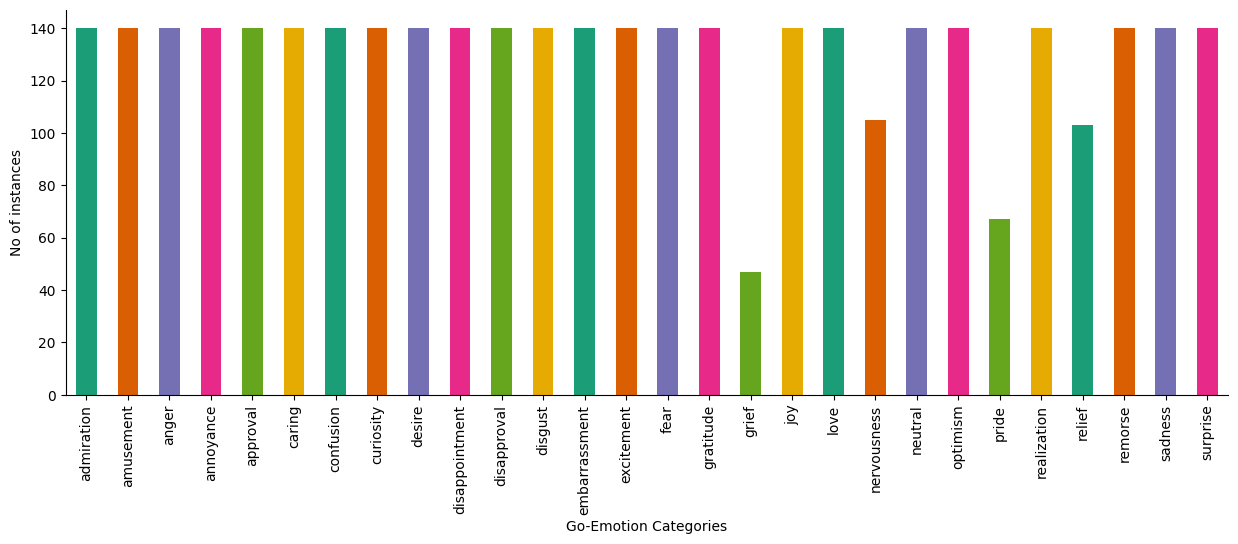

In [56]:
plot_data_distribution(df=combined_dataset, ax=plt.gca(), ylabel='No of instances', xlabel='Go-Emotion Categories', category='go_label', kind='bar')

Next, let's look at the distribution based on the Ekman's scheme of each dataset.

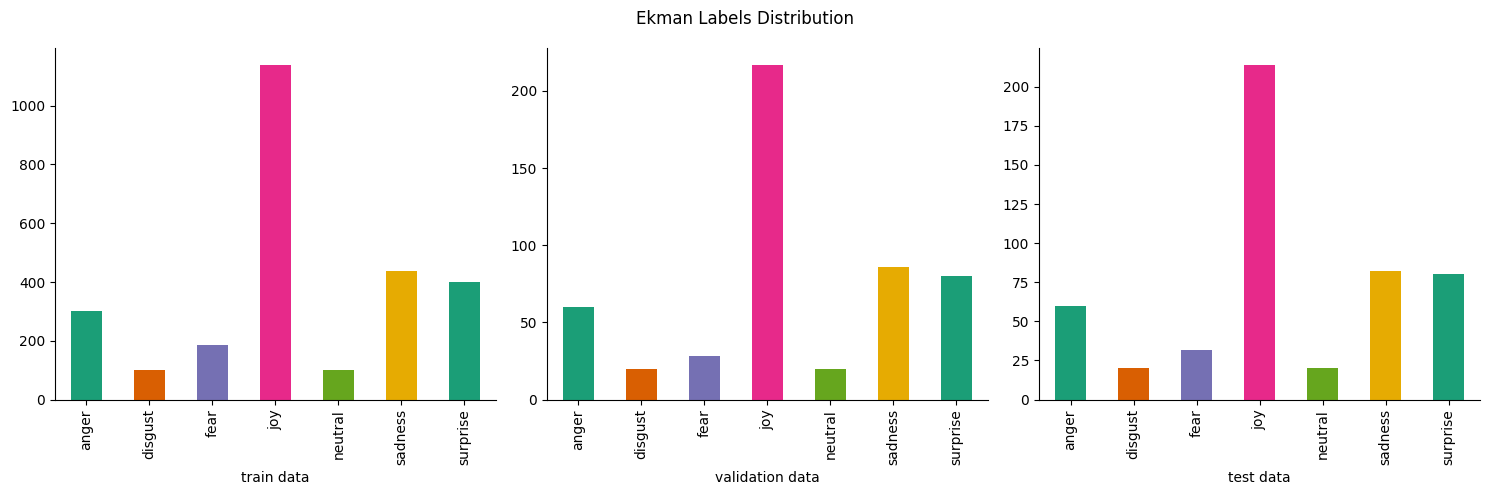

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Ekman Labels Distribution')
plot_data_distribution(df=dataset['train'], ax=axes[0], xlabel='train data')
plot_data_distribution(df=dataset['val'],   ax=axes[1], xlabel='validation data')
plot_data_distribution(df=dataset['test'],  ax=axes[2], xlabel='test data')
plt.tight_layout()

The number of joy text in our dataset is highest because the number of sub-emotion categories under joy of the Ekman's scheme is highest. 

<a name="classification"></a>
# **Section 3: Emotion Classification**


This section will show you how to classify emotion using BERT and T5 available at <a herf="https://huggingface.co/">Hugging Face</a>. The text classification involves two main process which are text pre-processing and text classification. For text pre-processing, it is a process where we transform a text into suitable format, such as from text to vector. Text tokenization is one of the transformation method which maps each word in the text to its word id creating a text representative vector. After the pre-processing, we pass the text vector to emotion classifier and wait for result.  

The following sub-sections will show you how to tokenize text and create emotion classifiers based on BERT and T5.

Install and import required packages.

In [ ]:
!pip install pytorch_lightning
!pip install csv-logger
!pip install lightning

In [3]:
from transformers import BertModel
from transformers import BertTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from torch import nn
import pytorch_lightning as pl
import torch
from lightning.pytorch.loggers import CSVLogger
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer


## BERT Emotion Classifier

In this tutorial, we illustrate the implementation based on torch and pytorch-lightning libraries.  

As explained earlier, we need to perform text tokeniation and create classifier. However, before that, let's create a Python class storing our data. We will use torch Dataset for implementation. The Dataset can be used to store our texts and their labels. Moreover, the stored texts and labels can be easily accessed using indexing. The code below shows and example of BERTDataset class which stores all the data.  

```python
class BERTDataset(Dataset):
    def __init__(self, df, datacolumn, labelcolumn):
        self.data = df
        self.texts = self.data[datacolumn].tolist()
        self.labels = self.data[labelcolumn].tolist()

    def __len__(self):
        return(len(self.texts))
```

The BERTDataset stores texts and their labels in self.texts and self.labels respectively. The texts and labels are from the data in the previous section which are in pandas Dataframe. The datacolumn and labelcolumn indicate which columns texts and labels are in.    


To access our data by index, we can add __getitem__ function to the Dataset class. The function will return text and label of the givin index. However, as we need to tokenized texts, we return a tokenized text instead. The __getitem__ function is shown below.

```python
def __getitem__(self,idx):
        # get text and label by index
        text = self.texts[idx]
        label = self.labels[idx]
        # tokenization
        encoding = self.tokenizer.encode_plus(
                                                text,
                                                max_length = self.max_length,
                                                add_special_tokens = True,
                                                padding = 'max_length',
                                                truncation = True,
                                                return_attention_mask = True,
                                                return_tensors = 'pt',)
        # return tokenized text and its label
        return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label),
                }
```

As we tokenize text in the __getitem__ function, we will need to include tokenizer to our class as well. Thus, we modify BERTDataset class a litle bit and put everything together. The finished BERTDataset class is shown below.

In [7]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, datacolumn, labelcolumn):
        self.data = df
        self.texts = self.data[datacolumn].tolist()
        self.labels = self.data[labelcolumn].tolist()
        # tokenizer and necessary parameter
        self.tokenizer = tokenizer 
        self.max_length = max_length

    def __len__(self):
        return(len(self.texts))

    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
                                                text,
                                                max_length = self.max_length,
                                                add_special_tokens = True,
                                                padding = 'max_length',
                                                truncation = True,
                                                return_attention_mask = True,
                                                return_tensors = 'pt',)

        return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label),
                }

Now, our dataset and text tokenization are ready. Let's start creating BERT emotion classifier. First, we need to create a classification layer which is connected to BERT. This is because BERT itself cannot perform classification taks. However, BERT can understand English text and encode the text into a vector. Next, we will pass the encoded text vector to the classification layer for emotion classification.   

For classification layer, we will create a simple neuron network comprise of linear layer, dropout layer, and output layer. We will use pytorch-lightnight for implementation as shown below.  

```python
class BERTClassifier(pl.LightningModule):
    def __init__(self, model, num_class, emotion_index):
        super(BERTClassifier, self).__init__()
        self.model = model
        self.num_class = num_class
        self.emotion_index = emotion_index
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, self.num_class) # output layer

```

The above code shows the implementation of our BERTclassifier. We define necessary elements. Next. let's setup the forward function which will connect all theses layers and classify emotion.

```python
def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        pooler = outputs[0][:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        logits = self.classifier(pooler)

        return logits
```

The forward function shows the sequence of layers explained previously. The function return the result of the last layer which are classification output. Next, we will create a function for emotion classification which connect BERTDataset to BERTClassifier. 

```python
def emo_classification(self, dataset):
        predictions = []
        for _d in dataset:
            logits = self(_d['input_ids'].unsqueeze(0), _d['attention_mask'].unsqueeze(0))
            _, pred = torch.max(logits, dim = 1)
            index= pred.numpy()[0]
            predictions.append(self.emotion_index[index])
        return predictions
```


The emotion_classification will interate over the dataset and classify emotion for each text. As we already tokenized the text, this function will access the tokenized text then pass it to forward function. Then we store the classifation results are return them. The below code cell show the full class of BERTClassifier.

In [ ]:
class BERTClassifier(pl.LightningModule):
    def __init__(self, model, num_class, emotion_index):
        super(BERTClassifier, self).__init__()
        self.model = model
        self.num_class = num_class
        self.emotion_index = emotion_index
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, self.num_class)


    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        pooler = outputs[0][:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        logits = self.classifier(pooler)

        return logits

    def emo_classification(self, dataset):
        predictions = []
        for _d in dataset:
            logits = self(_d['input_ids'].unsqueeze(0), _d['attention_mask'].unsqueeze(0))
            _, pred = torch.max(logits, dim = 1)
            index= pred.numpy()[0]
            predictions.append(self.emotion_index[index])
        return predictions


With classifier and dataset, let's setup parameter and perform the classification.

In [ ]:
# parameters
CLASSES = 7
DATACOLUMN = 'text'
LABLECOLUMN = 'ekman_index'
EMOTION_INDEX = {0: 'anger', 
                 1: 'disgust', 
                 2: 'fear', 
                 3: 'joy', 
                 4: 'neutral', 
                 5: 'sadness', 
                 6: 'surprise'}

We use BERT model called <a href='https://huggingface.co/google-bert/bert-base-uncased'>bert-base-uncased</a>. The model is available on Hugging Face website. 

In [ ]:
# download BERT model and init BERT classifier

BERT_MODEL = BertModel.from_pretrained("bert-base-uncased")
BERT_TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

BERTcls = BERTClassifier(
    model=BERT_MODEL,
    num_class=CLASSES,
    emotion_index = EMOTION_INDEX)



In [ ]:
# get data ready
# we sample 10 instances from dataset['test']
# you can try the whole data by replacing data with dataset['test']

data = dataset['test'].sample(n=10, random_state=1)

Bertdata = BERTDataset(df = data, 
                       tokenizer = BERT_TOKENIZER, 
                       max_length = BERT_TOKENIZER.model_max_length,
                       datacolumn = DATACOLUMN, 
                       labelcolumn = LABLECOLUMN)

In [ ]:
# classification
bert_pred = BERTcls.emo_classification(Bertdata)
bert_pred

## T5 Emotion Classifier

We showed how to use BERT for emotion classification. For T5, the process is similar to that of BERT which we need to create Dataset and T5 classifier. Howver, the difference is that T5 can generate text on its own which we do not need to create a classification layer. Therefore, we can use T5 to directly generate emotion.  

For text generation, we need to be careful of the length of text generation because we do not want the classifier to over generate. In our case, we want the classifier to generate one emotion categories not a full sentences. Therefore, we need to limit the length of generated text. To do that, let's first observe the length of tokenized emotion categories.

In [ ]:
# load T5 and tokenizer 

T5_MODEL = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True)
T5_TOKENIZER = T5Tokenizer.from_pretrained("t5-small")

As shown in the above cell, we use T5 model called <a href='https://huggingface.co/google-t5/t5-small'>t5-small</a>. It is one of the model in T5 series, and the model's size is smallest. 

In [ ]:
# try tokenize emotion categories
DATACOLUMN = 'text'
LABLECOLUMN = 'ekman_label'

generated_output_length = [(e, len(T5_TOKENIZER.encode(e)), T5_TOKENIZER.encode(e)) for e in dataset['train'][LABLECOLUMN].unique()]
output_length_df = pd.DataFrame(generated_output_length, columns=['Emotion', 'No. tokens', 'Token ids'])
output_length_df

The above output shows that the maximum token lengths is 2. This means that we will limit the length of generated text to 2. Next, let's defined our dataset and T5 classifier.  

For dataset, we will use the same class for implementation 'Dataset'. Unlike BERT, before text tokenization, we need to add instruction text as a prefix to tell T5 what to do. In our example, we add 'emotion classification:' before the text. Then tokenize the text as usual. 

In [30]:
class T5Dataset(Dataset):
    def __init__(self, df, tokenizer, text_maxlength, label_maxlength, datacolumn, labelcolumn):
        self.data = df
        self.texts = self.data[datacolumn].tolist()
        self.labels = self.data[labelcolumn].tolist()
        self.tokenizer = tokenizer
        self.text_maxlength = text_maxlength
        self.label_maxlength = label_maxlength
        
    def __len__(self):
        return(len(self.texts))

    def __getitem__(self,idx):
        # T5 transformers performs different tasks by prepending the particular prefix to the input text.
        # In order to avoid dtype mismatch, as T5 is text-to-text transformer, the datatype must be string
        text = "emotion classification:" + str(self.texts[idx])
        label = str(self.labels[idx]).lower()
        text_tokenizer = self.tokenizer(text, max_length=self.text_maxlength, padding="max_length")
        label_tokenizer = self.tokenizer(label, max_length=self.label_maxlength, padding="max_length")

        return {
            "input_ids": torch.tensor(text_tokenizer["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(text_tokenizer["attention_mask"], dtype=torch.long),
            "label_ids": torch.tensor(label_tokenizer["input_ids"], dtype=torch.long),
            "label_mask": torch.tensor(label_tokenizer["attention_mask"], dtype=torch.long)
        }

For classifier, T5 comes with generate function which will take tokenized text as input and generate output directly. This means we do not need to create a forward function as we did with BERT. 

In [ ]:
class T5Classifier(pl.LightningModule):
    def __init__(self, model, tokenizer, generated_max_length):
        super(T5Classifier, self).__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.generated_max_length = generated_max_length
    
    def emo_classification(self,dataset):
        predictions = []
        for _d in dataset:
            pred = self.model.generate(input_ids=_d['input_ids'].unsqueeze(0),
                                         attention_mask=_d['attention_mask'].unsqueeze(0),
                                         max_length=self.generated_max_length)
            _pred = self.tokenizer.decode(pred[0],skip_special_tokens=True)
            predictions.append(_pred)
        return predictions
        

The classification concept is similar to that of BERT. Firstly, we interate over the dataset and generate emotion for each text. The generated text length is limited to 2. Then, we store all the prediction and return them.  

Now, the classifier and dataset are ready. Let's try classify emotion.

In [ ]:
# Output max length
OUTPUTLENGTH = output_length_df['No. tokens'].max()

T5cls = T5Classifier(
    model=T5_MODEL,
    tokenizer=T5_TOKENIZER,
    generated_max_length=2)

t5data = T5Dataset(df = data, 
                       tokenizer = T5_TOKENIZER, 
                       text_maxlength = T5_TOKENIZER.model_max_length,
                       label_maxlength = 2,
                       datacolumn = DATACOLUMN, 
                       labelcolumn = LABLECOLUMN)

In [ ]:
# classification result
t5_pred = T5cls.emo_classification(t5data)
t5_pred

To this point, we illustrated how to classify emotion using BERT and T5. Next section will show you how to evaluate performance of the two classifier. 

<a name="evaluation"></a>
# **Section 4: Model Evaluation**

In this section, we will evaluate emotion classification performance of two classifiers, BERT and T5. We will use accuracy to compare the performace of the two classifiers. First let's defined accuracy function. The accuracy is the ratio of number of correctly predicted texts and total number of texts. The accuracy function is defined below.

In [16]:
# accuracy function
def accuracy(actual_label,pred):
    return sum([1 if a == p else 0 for a,p in zip(actual_label,pred)])/len(pred)

Next, let's look at our classification results and the sampled data.

In [ ]:
data = data.loc[:, ['text','ekman_label']]
data['bert'] = bert_pred
data['t5'] = t5_pred
data

Next, let's calculate accuracy of each classifier and compare them.

In [ ]:
performance = {} 
performance['bert'] = [accuracy(data.ekman_label.tolist(), data.bert.to_list())]
performance['t5'] = [accuracy(data.ekman_label.tolist(), data.t5.to_list())]

perm = pd.DataFrame(performance)
perm

In [ ]:
perm.plot.bar()

As can be seen, the performance of the two classifers is quit low. In the next section, we will show you how to improve the performance of the two classifiers by tuning them.

<a name="fine-tuning"></a>
# **Section 5: Guide to Model Fine-tuning**

To improve the perofrmance of our classifier, we need to tune the classifier which will help them adapt to our emotion classification task. The tuning process is a supervised learning where the classifiers learn how to classify emotion based on given examples (training data). Each round of training is called epoch and for each epoch, we divine data into batches. The classifiers will learnt at the end of each batch by updating its weights. 

Therefore, we will create a training loop providing texts and their labels for the classifiers to learn. During the process, we also provide a set of data which will be used for validating our classifiers at the end of each round of leanring.  

For implementation, we will use the defined BERT and T5 classes earlier. 



## BERT Classifier tuning  

Before we drive into training and validating, we first need to create a method for divining our data into batches for training. It can also be used to provind data for validating and testing. We will use DataModule of pytorch-lightning for the implementataion. The DataModule stores train, validation, and test dataset and facilitate batch process for tuning process. The code below show the DataModule class. 

```python
class BERTDataModule(pl.LightningDataModule):
    def __init__(self, traindf, valdf, testdf, batch_size, tokenizer, max_length, datacolumn, labelcolumn):
        super().__init__()
        # dataset
        self.traindf = traindf
        self.valdf = valdf
        self.testdf = testdf
        self.datacolumn = datacolumn
        self.labelcolumn = labelcolumn
        # parameters 
        self.batch_size = batch_size
        self.max_length = max_length
        # tokenizer
        self.tokenizer = tokenizer

    def setup(self, stage=None):
        self.train_dataset = BERTDataset( self.traindf, self.tokenizer, self.max_length, self.datacolumn, self.labelcolumn)
        self.val_dataset = BERTDataset( self.valdf, self.tokenizer, self.max_length, self.datacolumn, self.labelcolumn)
        self.test_dataset = BERTDataset( self.testdf, self.tokenizer, self.max_length, self.datacolumn, self.labelcolumn)
        
```

In setup function, the BERTDataModule creates BERTDataset objects of train, validate, and test dataset, and stores them in its class. Next, we will add functions to provide access to each of the BERTDataset objects as shown below.

```python
    def train_dataloader(self):
        return DataLoader( self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader( self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader( self.test_dataset, batch_size=self.batch_size)
```

The above functions will be called during training, validating, and testing steps. These functions return a DataLoader object with batch_size parameters. The final look of our class is shown below.



In [ ]:


class BERTDataModule(pl.LightningDataModule):
    def __init__(self, traindf, valdf, testdf, batch_size, tokenizer, max_length, datacolumn, labelcolumn):
        super().__init__()
        # dataset
        self.traindf = traindf
        self.valdf = valdf
        self.testdf = testdf
        self.datacolumn = datacolumn
        self.labelcolumn = labelcolumn
        # parameters 
        self.batch_size = batch_size
        self.max_length = max_length
        # tokenizer
        self.tokenizer = tokenizer

    def setup(self, stage=None):
        self.train_dataset = BERTDataset( self.traindf, self.tokenizer, self.max_length, self.datacolumn, self.labelcolumn)
        self.val_dataset = BERTDataset( self.valdf, self.tokenizer, self.max_length, self.datacolumn, self.labelcolumn)
        self.test_dataset = BERTDataset( self.testdf, self.tokenizer, self.max_length, self.datacolumn, self.labelcolumn)

    def train_dataloader(self):
        return DataLoader( self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader( self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader( self.test_dataset, batch_size=self.batch_size)

We have setup DataModule for tuning. Next, let's modify our BERTClassifier. We need to add three functions for training, validating, and testing.  

```python
def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        logits = self(input_ids, attention_mask)
        _, preds = torch.max(logits, dim = 1)
        loss = nn.CrossEntropyLoss()(logits, labels)

        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc',(preds == labels).sum() / len(labels), on_epoch=True)
        return loss
```

The training_step takes batch data provided by the train_dataloader of BERTDataModule. For each batch, the input will be pass to forward function. Then we calculate loss and return it. We also keep tracking loss and accuracy during the training.  



As for validating_step, the code is similar to that of training_step. However, during validation, the function will call val_dataloader of the BERTDataModule for validation dataset. The rest of the process is the same. 

```python
def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"]

    logits = self(input_ids, attention_mask)
    _, preds = torch.max(logits, dim = 1)
    loss = nn.CrossEntropyLoss()(logits, labels)

    self.log('val_loss', loss)
    self.log('val_acc', (preds == labels).sum() / len(labels))
    return loss

```

In test_step, we do not need to return loss and we want to test our classifier based on the test dataset. Still, the process is similar the the other two steps.

```python
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        logits = self(input_ids=input_ids,
                      attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        _, preds = torch.max(logits, dim = 1)

        self.log('test_loss', loss)
        self.log('test_acc', (preds == labels).sum() / len(labels))
```

We have defined all functions. The last step is to define an optimizer used for updating our classifier. The optimizer needs parameters such as learning rate, number of training steps, and number of warmup steps. These parameters will be setup during classifier init. In our example, we use Adam optimizer as shown below.

```python
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0,
                num_training_steps=self.epoch*self.train_size)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
```

The modified BERTClassifier is shown below.

In [ ]:
class BERTClassifier(pl.LightningModule):
    def __init__(self, model, num_class, learning_rate, epoch, train_size):
        super(BERTClassifier, self).__init__()
        self.model = model
        self.num_class = num_class
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.train_size = train_size
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, self.num_class)


    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        pooler = outputs[0][:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        logits = self.classifier(pooler)

        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        logits = self(input_ids, attention_mask)
        _, preds = torch.max(logits, dim = 1)
        loss = nn.CrossEntropyLoss()(logits, labels)

        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc',(preds == labels).sum() / len(labels), on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        logits = self(input_ids, attention_mask)
        _, preds = torch.max(logits, dim = 1)
        loss = nn.CrossEntropyLoss()(logits, labels)

        self.log('val_loss', loss)
        self.log('val_acc', (preds == labels).sum() / len(labels))
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        logits = self(input_ids=input_ids,
                      attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        _, preds = torch.max(logits, dim = 1)

        self.log('test_loss', loss)
        self.log('test_acc', (preds == labels).sum() / len(labels))

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0,
                num_training_steps=self.epoch*self.train_size)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

Next, let's setup parameter, datamodule, and classifier. 

In [ ]:
# parameters 
EPOCH = 2 # two rounds of training
CLASSES = 7 # emotion categories 
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
TRAIN_SIZE = len(dataset['train'])
MAX_LENGTH = BERT_TOKENIZER.model_max_length #512

DATACOLUMN = 'text'
BERTLABLECOLUMN = 'ekman_index'

In [ ]:
# datamodule
BERTdata_module = BERTDataModule(traindf=dataset['train'],
                               valdf=dataset['val'],
                               testdf=dataset['test'],
                               tokenizer=BERT_TOKENIZER,
                               batch_size=BATCH_SIZE,
                               max_length=MAX_LENGTH,
                               datacolumn=DATACOLUMN,
                               labelcolumn=BERTLABLECOLUMN)
BERTdata_module.setup()

In [ ]:
# classifier
BERTcls = BERTClassifier(
    model=BERT_MODEL,
    num_class=CLASSES,
    learning_rate=LEARNING_RATE,
    epoch=EPOCH,
    train_size=TRAIN_SIZE)

# unblock to print classifier structure
# BERTcls

We will create a log file to record tuning performance and losses using CSVLogger. For tuning, we will use pytorch trainer.

In [ ]:
# setup save path for log file
logger = CSVLogger("./logs", name='BERT_exp', version=1)

# using pytorch trainer for tuning
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

Before tuning, let's first test the classifier. Previously, we only test based on a small samples of our test dataset. Now, we will test the classifier on the whole test dataset. 

In [ ]:
trainer.test(BERTcls, BERTdata_module)

We can see the result above. It is quit low. Let's strat tuning then test it again. 

In [ ]:
trainer.fit(BERTcls, BERTdata_module)

In [ ]:
# test again
trainer.test(BERTcls, BERTdata_module)

We can see the improvement of the classifier's performance. Next, let's review tuning/testing loss and performance. The information is stored in the log file in './logs/BERT_exp' directory.

In [ ]:
def GetTuningStats(path):
    metrices = pd.read_csv(path)
    training_metric = metrices[['train_acc_epoch','train_loss_epoch']].dropna().reset_index(drop=True)
    validate_metric = metrices[['val_acc','val_loss']].dropna().reset_index(drop=True)
    testing_metric = metrices[['test_acc']].dropna().reset_index(drop=True)
    merge_matrices = pd.merge(training_metric,validate_metric, left_index=True, right_index=True)
    return testing_metric, merge_matrices

In [ ]:
BERT_performance, BERT_losses = GetTuningStats('./logs/BERT_exp/version_1/metrics.csv')
BERT_performance

The improvement is obvious!!! Let's plot the losses.

In [ ]:
# losses of each epoch
BERT_losses[['train_loss_epoch','val_loss']].plot()
# accuracy of each epoch
BERT_losses[['train_acc_epoch','val_acc']].plot()

The below code show how to save and load the classifier for later use.

In [ ]:
# # saving
# torch.save(BERTcls.state_dict(), './bert.pt')
# # loading
# saved_model = BERTClassifier(
#     model=BERT_MODEL,
#     num_class=CLASSES,
#     learning_rate=LEARNING_RATE,
#     epoch=EPOCH,
#     train_size=TRAIN_SIZE)
# saved_model.load_state_dict(torch.load('./bert.pt'))
# saved_model.eval()

***

## T5 tuning

Tuning process of T5 is similar to BERT. We need to create DataModule and add training, testing, validating steps to T5Classifier. We also add optimizer to the classifier.  

The code below shows T5DatModule.

In [41]:
class T5DataModule(pl.LightningDataModule):
    def __init__(self, traindf, valdf, testdf, batch_size, tokenizer, text_maxlength, label_maxlength, datacolumn, labelcolumn):
        super().__init__()
        # dataset 
        self.datacolumn = datacolumn
        self.labelcolumn = labelcolumn
        self.traindf = traindf
        self.valdf = valdf
        self.testdf = testdf
        # parameters
        self.batch_size = batch_size
        self.text_maxlength = text_maxlength
        self.label_maxlength = label_maxlength
        # tokenizer
        self.tokenizer = tokenizer

    def setup(self, stage=None):
        self.train_dataset = T5Dataset( self.traindf, self.tokenizer, self.text_maxlength, self.label_maxlength, self.datacolumn, self.labelcolumn)
        self.val_dataset = T5Dataset( self.valdf, self.tokenizer, self.text_maxlength, self.label_maxlength, self.datacolumn, self.labelcolumn)
        self.test_dataset = T5Dataset( self.testdf, self.tokenizer, self.text_maxlength, self.label_maxlength, self.datacolumn, self.labelcolumn)

    def train_dataloader(self):
        return DataLoader( self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader( self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader( self.test_dataset, batch_size=self.batch_size)

T5DataModule is similar to that of BERT. The differences are that it stores T5Dataset which needs different parameters.  

In the previous section, we do not need forward function because we only generate emotions. However, for tuning, we need to define forward function to return loss.

```python
    def forward(self, input_ids, attention_mask, labels=None, decoder_attention_mask=None):
        outputs = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask)
        return outputs.loss, outputs.logits
```

The forward function will pass a batch input through the model (T5). Then, it will return loss.  

Because the forward function return loss, the training_step function will directly return output from the forward function. In the function, we also record loss and training performance. For training performance, we use model's generate function to generate then compare the generated text with label.

```python
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label_ids"]
        decoder_attention_mask = batch["label_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        pred = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)

        self.log('train_acc', self.accuracy_score(output, labels), on_epoch=True)
        self.log('train_loss', loss,  on_epoch=True)

        return loss
```

The accuracy evaluation fuction is defined below.  

```python
    def accuracy_score(self,preds,labels):
        _preds = [self.tokenizer.decode(p,skip_special_tokens=True) for p in preds]
        _labels = [self.tokenizer.decode(l,skip_special_tokens=True) for l in labels]
        return sum([1 if _p==_l else 0 for _p ,_l in zip(_preds,_labels)])/len(_labels)
```

We decode the generated text and label. Then we calculate and return the accuracy score.

Validating step is similar to the training step. For testing step, we use T5 to generate text and call accuracy_score function to evaluate the performance of the classifier. The optimizer used for T5 is similart to that of BERT's. Therefore, T5Classifier can be defined as follows.

In [42]:
class T5Classifier(pl.LightningModule):
    def __init__(self, model, tokenizer, epoch, train_size, generated_max_length, learning_rate):
        super(T5Classifier, self).__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.epoch = epoch
        self.train_size = train_size
        self.generated_max_length = generated_max_length
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask, labels=None, decoder_attention_mask=None):
        outputs = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask)
        return outputs.loss, outputs.logits

    def accuracy_score(self,preds,labels):
        _preds = [self.tokenizer.decode(p,skip_special_tokens=True) for p in preds]
        _labels = [self.tokenizer.decode(l,skip_special_tokens=True) for l in labels]
        return sum([1 if _p==_l else 0 for _p ,_l in zip(_preds,_labels)])/len(_labels)


    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label_ids"]
        decoder_attention_mask = batch["label_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        pred = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)

        self.log('train_acc', self.accuracy_score(pred, labels), on_epoch=True)
        self.log('train_loss', loss,  on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label_ids"]
        decoder_attention_mask = batch["label_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        
        pred = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)

        self.log('val_acc', self.accuracy_score(pred, labels))
        self.log('val_loss', loss)

        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        output = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)
        self.log('test_acc', self.accuracy_score(output, batch["label_ids"]))

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0,
                num_training_steps=self.epoch*self.train_size)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

Now, let's setup parameters, datamodule, and classifier.

In [ ]:
# parameters
EPOCH = 2
BATCH_SIZE = 8
LABEL_LENGTH = 2
LEARNING_RATE = 2e-5
MODEL_MAX_LENGTH = T5_TOKENIZER.model_max_length

DATACOLUMN = 'text'
T5LABELCOLUMN = 'ekman_label'

In [ ]:
# datamodule
T5data = T5DataModule(traindf = dataset['train'],
                      valdf = dataset['val'],
                      testdf = dataset['test'],
                      batch_size = BATCH_SIZE,
                      tokenizer = T5_TOKENIZER,
                      text_maxlength = MODEL_MAX_LENGTH,
                      label_maxlength = LABEL_LENGTH,
                      datacolumn = DATACOLUMN,
                      labelcolumn = T5LABELCOLUMN)
T5data.setup()

In [ ]:
# save directory
logger = CSVLogger("./logs", name='T5_ekman', version=1)

# classifier
T5cls = T5Classifier(model = T5_MODEL,
                     tokenizer = T5_TOKENIZER,
                     epoch = EPOCH,
                     train_size = TRAIN_SIZE,
                     generated_max_length = LABEL_LENGTH,
                     learning_rate=LEARNING_RATE)

In [ ]:
# trainer for tuning
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

Let's evaluate our classifier before tuning

In [ ]:
trainer.test(T5cls, T5data)

Start tuning

In [ ]:
trainer.fit(T5cls, T5data)

Evaluate again!!

In [ ]:
trainer.test(T5cls, T5data)

Next, let's review performance and losses.

In [ ]:
t5_performance , t5_losses = GetTuningStats('./logs/T5_ekman/version_1/metrics.csv')
t5_performance

In [ ]:
t5_losses[['train_loss_epoch','val_loss']].plot()
t5_losses[['train_acc_epoch','val_acc']].plot()

T5 classifier can also be saved as same as BERT classifier.

In [ ]:
# # saving
# torch.save(T5cls.state_dict(), './t5.pt')
# # loading
# saved_model = T5Classifier(model = T5_MODEL,
                    #  tokenizer = T5_TOKENIZER,
                    #  epoch = EPOCH,
                    #  train_size = TRAIN_SIZE,
                    #  generated_max_length = LABEL_LENGTH,
                    #  learning_rate=LEARNING_RATE)
# saved_model.load_state_dict(torch.load('./t5.pt'))
# saved_model.eval()

Let's compare the performance of the two classifier before and after tuning.

In [ ]:
performances = pd.concat([BERT_performance, t5_performance], axis=1)
performances.columns = ['bert','t5']
performances['status'] = ['before', 'after']
performances.plot.bar(x='status')

We can see the huge differences before and after tuning. The dataset used for training is just a small sample, and the full dataset can be download here (<a href='https://huggingface.co/datasets/google-research-datasets/go_emotions'>GoEmotion full dataset</a>). We can improve the performance by tuning more and adjusting tuning parameters.  
